# Homework 1 
## INF 552: Machine Learning for Data Informatics 
### Jungho Choi (junghoch@usc.edu) 

1.Vertebral Column Data Set

This Biomedical data set was built by Dr. Henrique da Mota during a medical residence
period in Lyon, France. Each patient in the data set is represented in the data set
by six biomechanical attributes derived from the shape and orientation of the pelvis
and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle,
sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is
used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and
Abnormal (AB). In this exercise, we only focus on a binary classification task NO=0
and AB=1.

(a) Download the Vertebral Column Data Set from: https://archive.ics.uci.edu/ml/datasets/Vertebral+Column.



In [46]:
# Downloaded the Vertebral Column Dataset from the UCI website above in my current working directory 
# And loaded the dataset onto this jupyter notebook, changed the column names with the 6 biomechanical attributes 

from __future__ import division
%matplotlib inline  
import math
from astropy.table import Table 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

v_data = pd.read_csv('/Users/apple/inf552/vertebral_column_data/column_2C.dat', sep='\s+', header=None, skiprows=0)
v_data.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class_labels']
v_data.head() # NOTE: dataset is read, but encoding to 1 and 0 for the class_labels will come later 

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class_labels
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


(b) Pre-Processing and Exploratory data analysis:

    i. Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.

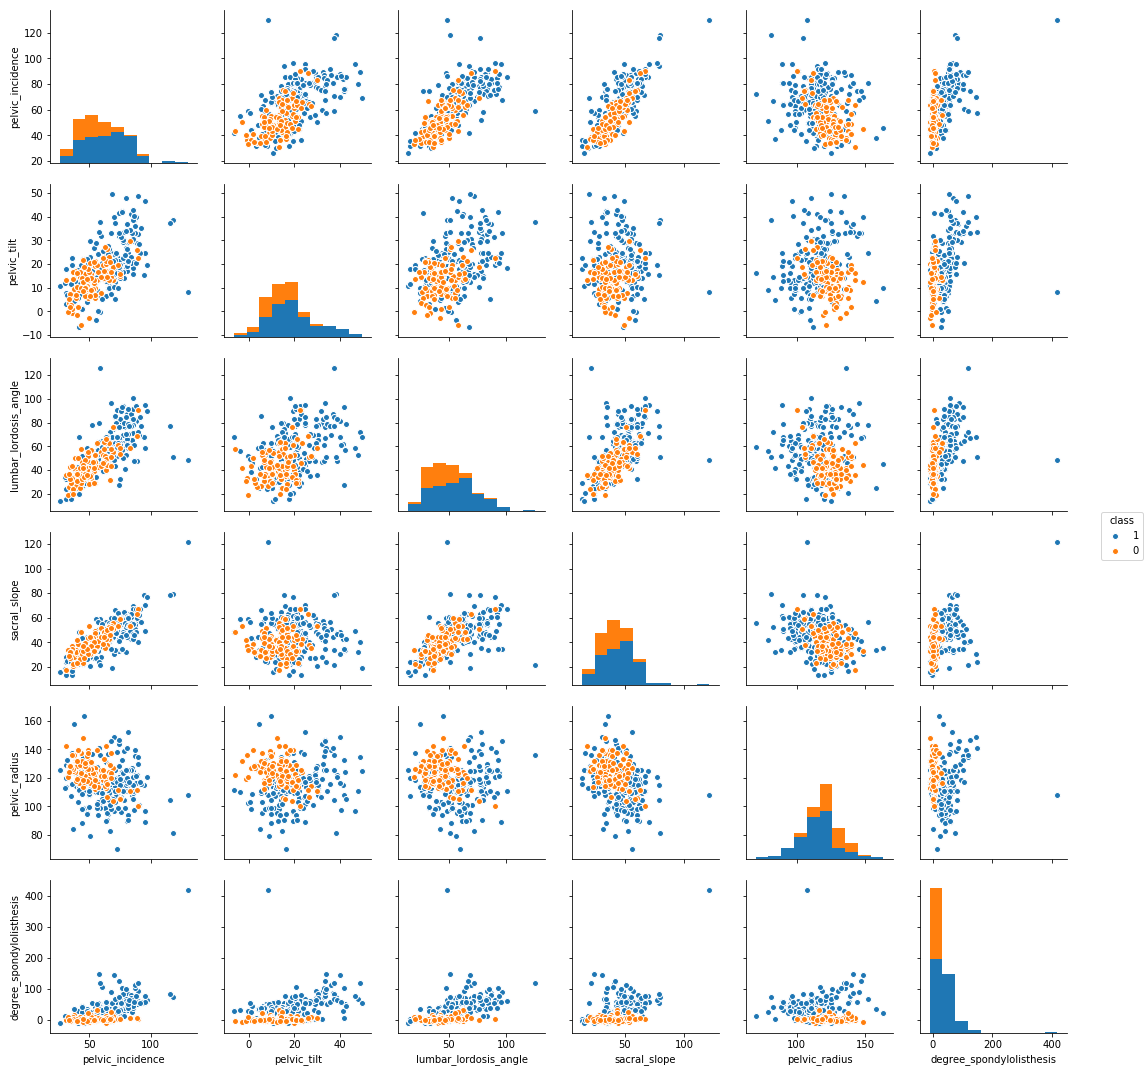

In [2]:
g = sns.pairplot(v_data, hue="class_labels")
new_title = 'class'
g._legend.set_title(new_title)
new_labels = [1, 0]
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

    ii. Make boxplots for each of the independent variables. Use color to show Classes 0 and 1 (see ISLR p. 129).

In [3]:
# After loading the dataset, added a column (column index 7) based on column index 6 for binary classification
# ex) 1 if AB; 0 if NO 

v_data['class'] = np.where(v_data.class_labels == 'NO', 0, 1)
new_v_data = v_data.drop('class_labels', axis = 1) # then drop the class_labels (AB/NO) since encoded
new_v_data.head() # now class is encoded for binary classification (0 and 1) and print out first 5 for demonstration

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


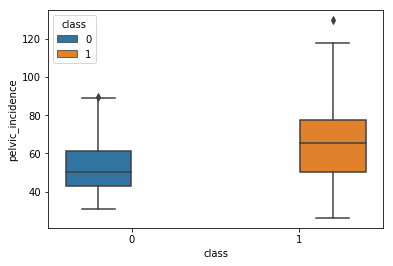

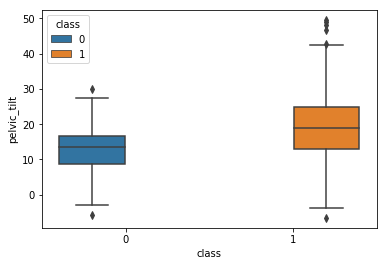

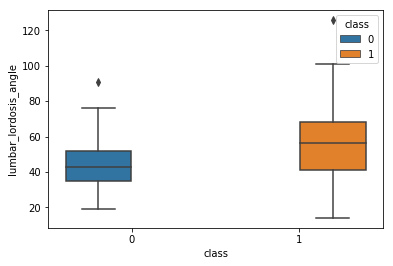

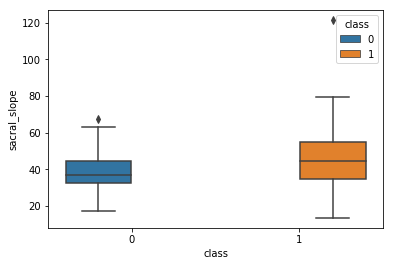

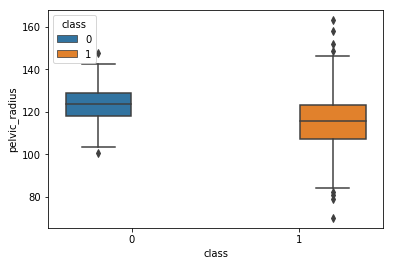

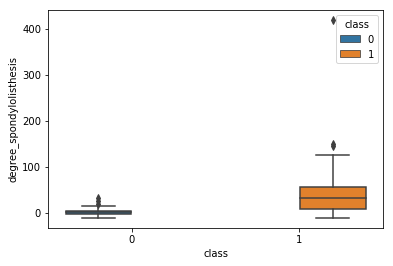

In [4]:
# boxplots using a loop 
# declare the independent variable names in a list, column_names

column_names = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
for i in range(len(column_names)):
    sns.boxplot(x="class", y=column_names[i], hue="class", data=new_v_data)
    plt.show()

    iii. Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [5]:
# split the dataset into feature vector and a label vector 
x_feature_vector = pd.DataFrame(new_v_data, columns = new_v_data.columns[:-1])
y_target_vector = new_v_data['class']

# seperate the feature vector depending on the class
class0_x = x_feature_vector.iloc[210:]
class1_x = x_feature_vector.iloc[:210]

# seperate the classes for label vector 
class0_y = y_target_vector.iloc[210:]
class1_y = y_target_vector.iloc[:210]




###### train data ######
### train: first 70 of class0 + first 140 of class1 ###

class0_first70_x = class0_x.iloc[:70]
class1_first140_x = class1_x.iloc[:140]
train_frame_x = [class0_first70_x, class1_first140_x]
# train feature vector
train_x_wo = pd.concat(train_frame_x)


class0_first70_y = class0_y.iloc[:70]
class1_first140_y = class1_y.iloc[:140]
train_frame_y = [class0_first70_y, class1_first140_y]
# train target vector 
train_y_wo = pd.concat(train_frame_y)




###### test data ######
### test: rest of data ###

class0_rest_x = class0_x.iloc[70:]
class1_rest_x = class1_x.iloc[140:]
test_frame_x = [class0_rest_x, class1_rest_x]
# test feature vector
test_x_wo = pd.concat(test_frame_x)


class0_rest_y = class0_y.iloc[70:]
class1_rest_y = class1_y.iloc[140:]
test_frame_y = [class0_rest_y, class1_rest_y]
# test target vector 
test_y_wo = pd.concat(test_frame_y)

(c) Classification using KNN on Vertebral Column Data Set

    i. Write code for k-nearest neighbors with Euclidean metric (or use a software package).

In [6]:
# Create KNN instance
# n_neighbors -> argument identifies the amount of neighbors used to ID classification

k = 1 # arbitrary k value at first to declare an instance of knn 
knn = KNeighborsClassifier(n_neighbors=k)

# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# documentation of scikit-learn's KNN 

    ii. Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. Plot train and test errors in terms of k for k ∈ {208, 205, . . . , 7, 4, 1, } (in reverse order). You are welcome to use smaller increments of k. Which k^* is the most suitable k among those values? Calculate the confusion matrix, true positive rate, true negative rate, precision, and F-score when k = k^∗.

In [7]:
# created a function to determine error rates for both train and test 

def error_rate(start_k, increment, train):
    """ Calculates training error / testing error 
    
    @param start_k: starting k for KNN (int)
    @param increment: decrement number to decrease k's value (int)
    @param train: the desired error rate, either train or test (boolean)
    @return list of error rates 
    """
    error_rate_list = []
    if train == True: # for train error
        predict_x = train_x_wo
        classify_y = train_y_wo 
    else: # for test error 
        predict_x = test_x_wo 
        classify_y = test_y_wo 
    while (start_k >= 1):
        knn = KNeighborsClassifier(n_neighbors=start_k) # create KNN instance
        knn.fit(train_x_wo, train_y_wo) # fit (train) the model 
        pred_i = knn.predict(predict_x) # make predictions 
        error_rate_list.append(np.mean(pred_i != classify_y)) 
        start_k = start_k - increment
    return error_rate_list

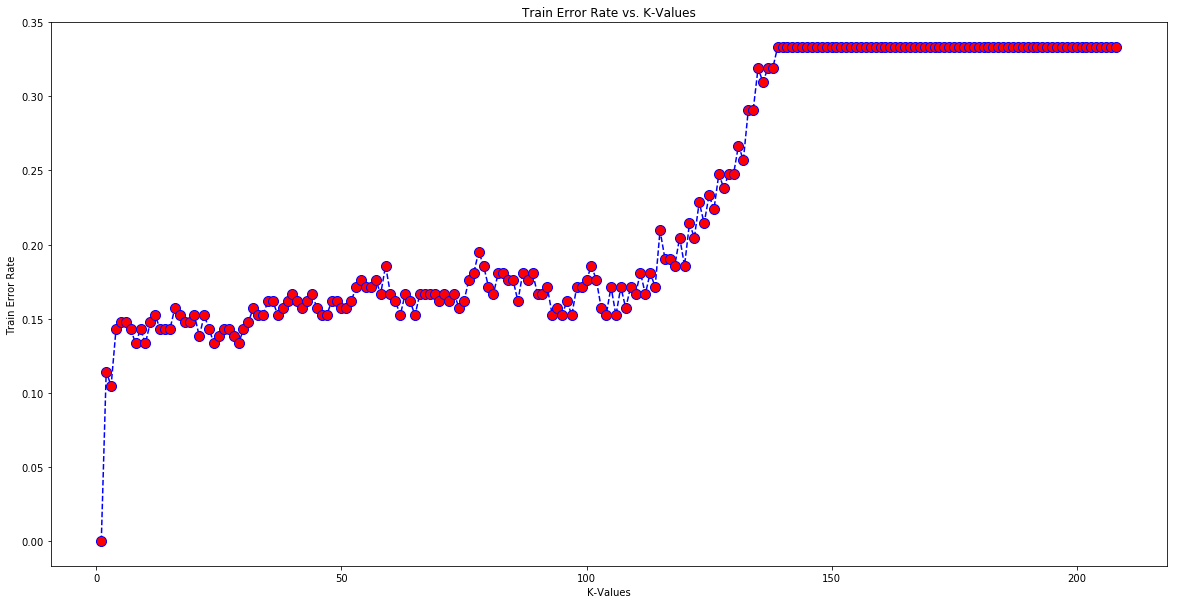

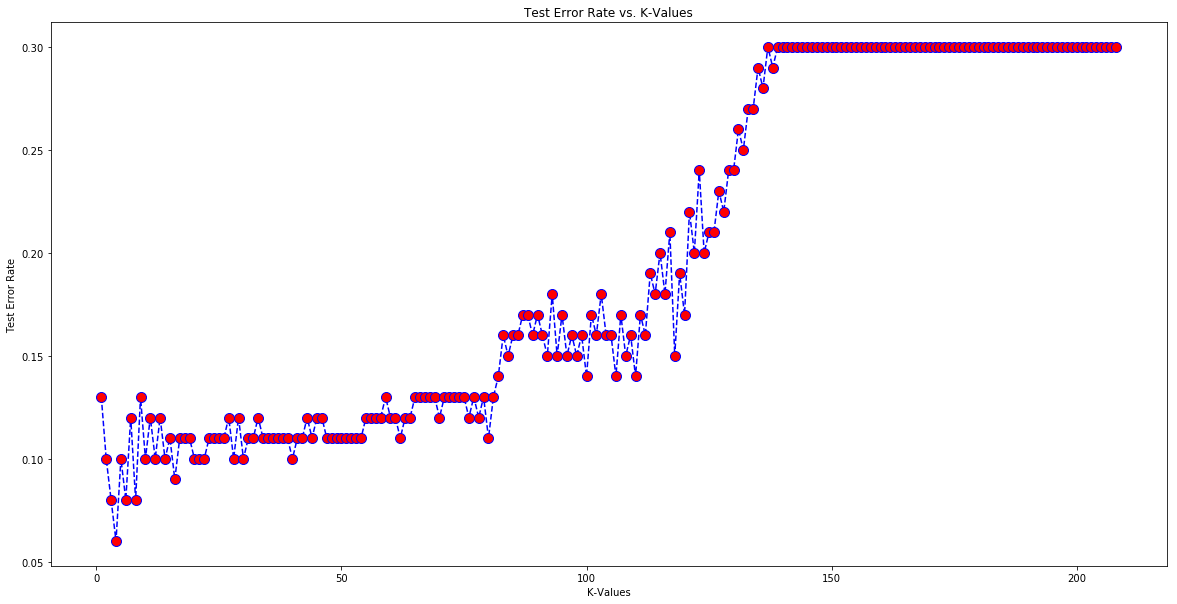

In [8]:
train_error = error_rate(208, 1, True)
test_error = error_rate(208, 1, False)

train_error_reversed = list(reversed(train_error))
plt.figure(figsize=(20,10))
plt.plot(range(1,209), train_error_reversed, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Train Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Train Error Rate')
plt.show()

test_error_reversed = list(reversed(test_error))
plt.figure(figsize=(20,10))
plt.plot(range(1,209), test_error_reversed, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Test Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Test Error Rate')
plt.show()

    Upon investigating the test error, when K = 4, the KNN algorithm on this dataset achieves the lowest test error. 
    Only considering the lowest test error (or highest accuracy) we choose K = 4 

In [22]:
# Retrain model using optimal k-value
knn_optimal = KNeighborsClassifier(n_neighbors=4)
knn_optimal.fit(train_x_wo, train_y_wo)
pred_optimal = knn_optimal.predict(test_x_wo)
print(classification_report(test_y_wo, pred_optimal))
print("Now, accuracy is 94%")
print("")

# Print out confusion matrix
cmat = confusion_matrix(test_y_wo, pred_optimal)

print("Confusion Matrix")
print(cmat) 
print("")

#in binary classification, the count of true negatives is C_{0,0}, 
#false negatives is C_{1,0}, 
#true positives is C_{1,1} 
#and false positives is C_{0,1}
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

tn, fp, fn, tp = confusion_matrix(test_y_wo, pred_optimal).ravel()

print('TP - True Negative: ' + str(tn))
print('FP - False Positive: ' + str(fp))
print('FN - False Negative: ' +str(fn))
print('TN - True Positive: ' + str(tp))

tpr = tp / (tp+fn)
tnr = tn / (tn+fp)
ppv = tp / (tp+fp)
f_score = 2 * ppv * tpr / (ppv + tpr)

print("")
print("True Positive Rate (TPR): TPR = TP / (TP+FN) = " + str(tpr))
print("True Negative Rate (TNR): TNR = TN / (TN+FP) = " + str(tnr))
print("Precision: PPV = TP / (TP+FP) = " + str(ppv))
print("F-Score: F_1 = 2 * PPV * TPR / (PPV + TPR) = " + str(f_score))

             precision    recall  f1-score   support

          0       0.96      0.83      0.89        30
          1       0.93      0.99      0.96        70

avg / total       0.94      0.94      0.94       100

Now, accuracy is 94%

Confusion Matrix
[[25  5]
 [ 1 69]]

TP - True Negative: 25
FP - False Positive: 5
FN - False Negative: 1
TN - True Positive: 69

True Positive Rate (TPR): TPR = TP / (TP+FN) = 0.985714285714
True Negative Rate (TNR): TNR = TN / (TN+FP) = 0.833333333333
Precision: PPV = TP / (TP+FP) = 0.932432432432
F-Score: F_1 = 2 * PPV * TPR / (PPV + TPR) = 0.958333333333


    iii. Since the computation time depends on the size of the training set, one may only use a subset of the training set. Plot the best test error rate, which is obtained by some value of k, against the size of training set, when the size of training set is N ∈ {10, 20, 30, . . . , 210}. Note: for each N, select your training set by choosing the first bN/3c rows of Class 0 and the first N − floor(N/3) rows of Class 1 in the training set you creatd in 1(b)iii. Also, for each N, select the optimal k from a set starting from k = 1, increasing by 5. For example, if N = 200, the optimal k is selected from {1, 6, 11, . . . , 196}. This plot is called a Learning Curve.

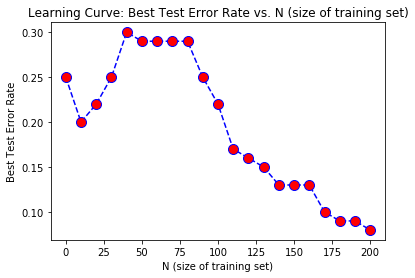

In [27]:
best_n_error = [] 
n = 10 
count = 1 
while (n <= 210):
    class0_train_x = class0_x.iloc[:int(math.floor(n/3))]
    class1_train_x = class1_x.iloc[:int(n-math.floor(n/3))]
    train_frame_x = [class0_train_x, class1_train_x]
    train_x = pd.concat(train_frame_x)
    
    class0_train_y = class0_y.iloc[:int(math.floor(n/3))]
    class1_train_y = class1_y.iloc[:int(n-math.floor(n/3))]
    train_frame_y = [class0_train_y, class1_train_y]
    train_y = pd.concat(train_frame_y)
    k_vals = [1+5*i for i in range(int(n/5))]
    
    kth_error_rate = [] 
    for i in range(len(k_vals)):
        knn = KNeighborsClassifier(n_neighbors = k_vals[i])
        knn.fit(train_x, train_y)
        kth_pred = knn.predict(test_x_wo)
        kth_error_rate.append(np.mean(kth_pred != test_y_wo))
    best_n_error.append(min(kth_error_rate))
    n = n + 10

x = [10 * x for x in range(21)] 
plt.plot(x, best_n_error, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Learning Curve: Best Test Error Rate vs. N (size of training set)')
plt.xlabel('N (size of training set)')
plt.ylabel('Best Test Error Rate')
plt.show()

Let us further explore some variants of KNN.

(d) Replace the Euclidean metric with the following metrics and test them. Summarize the test errors (i.e., when k = k^∗) in a table. Use all of your training data and select the best k when {1, 6, 11, . . . , 196}.

    i. Minkowski Distance:

        A. which becomes Manhattan Distance with p = 1.

In [53]:
list_err = []
k = 1 
while (k<=196):
    weight_knn_minkowski = KNeighborsClassifier(n_neighbors=k, p = 1)
    weight_knn_minkowski.fit(train_x_wo, train_y_wo)
    weight_pred_minkowski = weight_knn_minkowski.predict(test_x_wo)
    test_error = np.mean(weight_pred_minkowski != test_y_wo)
    k = k + 5
    list_err.append(test_error)
list_k = [1+5*i for i in range(40)]
t = Table([list_k, list_err], names=['k', 'test error rate'])
print(t)
print('')
print('k is optimal when k has 0.11 test error rate, which happens at k = 6, 11, and 26')

 k  test error rate
--- ---------------
  1            0.12
  6            0.11
 11            0.11
 16            0.12
 21            0.12
 26            0.11
 31            0.12
 36            0.13
 41            0.13
 46            0.13
...             ...
146             0.3
151             0.3
156             0.3
161             0.3
166             0.3
171             0.3
176             0.3
181             0.3
186             0.3
191             0.3
196             0.3
Length = 40 rows

k is optimal when k has 0.11 test error rate, which happens at k = 6, 11, and 26


        B. with log10(p) ∈ {0.1, 0.2, 0.3, . . . , 1}. In this case, use the k^∗ you found for the Manhattan distance in 1(d)iA. What is the best log10(p)?

In [55]:
log_p = 0.1 
k6 = []
k11 = []
k26 = []
while (log_p<=1):
    k = [6, 11, 26]
    for i in range(len(k)):
        knn_minkowski = KNeighborsClassifier(n_neighbors=k[i], p = 10 ** log_p)
        knn_minkowski.fit(train_x_wo, train_y_wo)
        pred_minkowski = knn_minkowski.predict(test_x_wo)
        test_error = np.mean(pred_minkowski != test_y_wo)
        if (k[i] == 6):
            k6.append(test_error)
        elif (k[i] == 11):
            k11.append(test_error)
        else: 
            k26.append(test_error)
    log_p = log_p + 0.1

print('k = 6, at log(' + str(k6.index(min(k6))) + '), p = ' + str(k6.index(min(k6))))
print('k = 11, at log(' + str(k11.index(min(k11))) + '), p = ' + str(k11.index(min(k11))))
print('k = 26, at log(' + str(k26.index(min(k26))) + '), p = ' + str(k26.index(min(k26))))

k_sub = [min(k6), min(k11), min(k26)]
#k_sub.index(min(k_sub)) -> 0 
print('')
print('Overall, when k = 6 and when p = 5, it achieves the lowest test error rate')

k = 6, at log(5), p = 5
k = 11, at log(0), p = 0
k = 26, at log(0), p = 0

Overall, when k = 6 and when p = 5, it achieves the lowest test error rate


        C. which becomes Chebyshev Distance with p → ∞

In [52]:
list_err = []
k = 1 
while (k<=196):
    weight_knn_minkowski = KNeighborsClassifier(n_neighbors=k, metric = 'chebyshev')
    weight_knn_minkowski.fit(train_x_wo, train_y_wo)
    weight_pred_minkowski = weight_knn_minkowski.predict(test_x_wo)
    test_error = np.mean(weight_pred_minkowski != test_y_wo)
    k = k + 5
    list_err.append(test_error)
list_k = [1+5*i for i in range(40)]
t = Table([list_k, list_err], names=['k', 'test error rate'])
print(t)
print('')
print('k is optimal when k has 0.08 test error rate, which happens at k = 16')

 k  test error rate
--- ---------------
  1            0.13
  6             0.1
 11            0.12
 16            0.08
 21            0.11
 26            0.12
 31            0.12
 36             0.1
 41            0.13
 46            0.12
...             ...
146             0.3
151             0.3
156             0.3
161             0.3
166             0.3
171             0.3
176             0.3
181             0.3
186             0.3
191             0.3
196             0.3
Length = 40 rows

k is optimal when k has 0.08 test error rate, which happens at k = 16


    ii. Mahalanobis Distance

In [61]:
list_err = []
k = 1 
while (k<=196):
    knn_mahal = KNeighborsClassifier(n_neighbors=k, algorithm = 'brute', metric ='mahalanobis', metric_params={'V':np.cov(train_x_wo)})
    knn_mahal.fit(train_x_wo, train_y_wo)
    pred_mahal = knn_mahal.predict(test_x_wo)
    test_error = np.mean(pred_mahal != test_y_wo)
    k = k + 5
    list_err.append(test_error)
list_k = [1+5*i for i in range(40)]
t = Table([list_k, list_err], names=['k', 'test error rate'])
print(t)
print('')
print('k is optimal when k has 0.16 test error rate, which happens at k = 6')

 k  test error rate
--- ---------------
  1            0.18
  6            0.16
 11            0.19
 16             0.2
 21            0.23
 26            0.21
 31            0.21
 36            0.23
 41            0.23
 46            0.24
...             ...
146             0.3
151             0.3
156             0.3
161             0.3
166             0.3
171             0.3
176             0.3
181             0.3
186             0.3
191             0.3
196             0.3
Length = 40 rows

k is optimal when k has 0.16 test error rate, which happens at k = 6


(e) The majority polling decision can be replaced by weighted decision, in which the weight of each point in voting is proportional to its distance from the query/test data point. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when k ∈ {1, 6, 11, 16, . . . , 196}.

    i. Euclidean

In [51]:
list_err = []
k = 1 
while (k<=196):
    weight_knn_minkowski = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
    weight_knn_minkowski.fit(train_x_wo, train_y_wo)
    weight_pred_minkowski = weight_knn_minkowski.predict(test_x_wo)
    test_error = np.mean(weight_pred_minkowski != test_y_wo)
    k = k + 5
    list_err.append(test_error)
list_k = [1+5*i for i in range(40)]
t = Table([list_k, list_err], names=['k', 'test error rate'])
print(t)
print('')
print('k is optimal when k has 0.1 test error rate, which happens at k = 6')

 k  test error rate
--- ---------------
  1            0.13
  6             0.1
 11            0.12
 16            0.11
 21            0.11
 26            0.11
 31            0.11
 36            0.11
 41            0.11
 46            0.11
...             ...
146            0.19
151            0.19
156             0.2
161            0.23
166            0.25
171            0.27
176            0.27
181            0.27
186            0.27
191            0.28
196            0.28
Length = 40 rows

k is optimal when k has 0.1 test error rate, which happens at k = 6


    ii. Manhattan 

In [48]:
list_err = []
k = 1 
while (k<=196):
    weight_knn_minkowski = KNeighborsClassifier(n_neighbors=k, weights = 'distance', p = 1)
    weight_knn_minkowski.fit(train_x_wo, train_y_wo)
    weight_pred_minkowski = weight_knn_minkowski.predict(test_x_wo)
    test_error = np.mean(weight_pred_minkowski != test_y_wo)
    k = k + 5
    list_err.append(test_error)
list_k = [1+5*i for i in range(40)]
t = Table([list_k, list_err], names=['k', 'test error rate'])
print(t)
print('')
print('k is optimal when k has 0.11 test error rate, which happens at k = 26')

 k  test error rate
--- ---------------
  1            0.12
  6            0.11
 11            0.11
 16            0.12
 21            0.11
 26             0.1
 31            0.11
 36            0.11
 41            0.11
 46            0.11
...             ...
146            0.18
151            0.19
156            0.21
161            0.24
166            0.25
171            0.27
176            0.27
181            0.27
186            0.27
191            0.28
196            0.29
Length = 40 rows

k is optimal when k has 0.11 test error rate, which happens at k = 26


    iii. Chebyshev

In [49]:
list_err = []
k = 1 
while (k<=196):
    weight_knn_minkowski = KNeighborsClassifier(n_neighbors=k, weights = 'distance', metric = 'chebyshev')
    weight_knn_minkowski.fit(train_x_wo, train_y_wo)
    weight_pred_minkowski = weight_knn_minkowski.predict(test_x_wo)
    test_error = np.mean(weight_pred_minkowski != test_y_wo)
    k = k + 5
    list_err.append(test_error)
list_k = [1+5*i for i in range(40)]
t = Table([list_k, list_err], names=['k', 'test error rate'])
print(t)
print('')
print('k is optimal when k has 0.11 test error rate, which happens at k = 16, 31, 36, 41, and 61')

 k  test error rate
--- ---------------
  1            0.13
  6            0.13
 11            0.12
 16            0.11
 21            0.12
 26            0.12
 31            0.11
 36            0.11
 41            0.11
 46            0.12
...             ...
146            0.19
151            0.21
156            0.21
161            0.23
166            0.26
171            0.26
176            0.26
181            0.27
186            0.27
191            0.27
196            0.28
Length = 40 rows

k is optimal when k has 0.11 test error rate, which happens at k = 16, 31, 36, 41, and 61


(f) What is the lowest training error rate you achieved in this exercise?

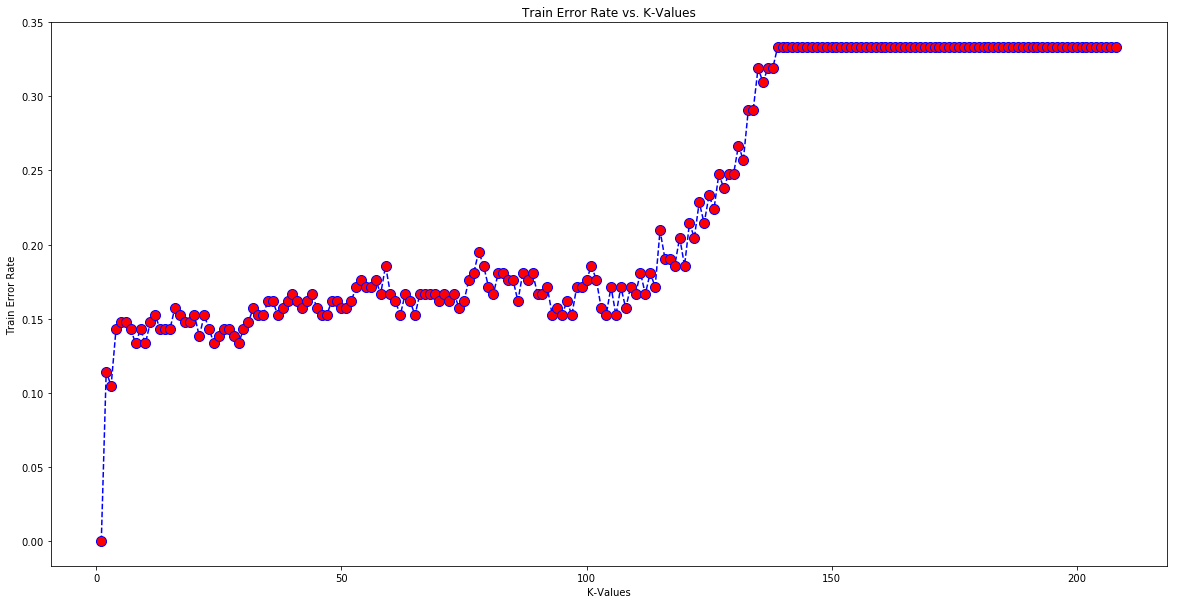


Please note that for this question, I assumed the whole homework.
As shown in the above graph, Train Error vs. K-values, when k = 1, for the KNN, in Euclidean metrics, it gives train error rate of 0 since it would always pick itself


In [59]:
train_error = error_rate(208, 1, True)
test_error = error_rate(208, 1, False)

train_error_reversed = list(reversed(train_error))
plt.figure(figsize=(20,10))
plt.plot(range(1,209), train_error_reversed, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Train Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Train Error Rate')
plt.show()

print('')
print('Please note that for this question, I assumed the whole homework.')
print('As shown in the above graph, Train Error vs. K-values, when k = 1, for the KNN, in Euclidean metrics, it gives train error rate of 0 since it would always pick itself')